## Validação dos pseudo-neagtivos com XGBoost

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
import joblib

c:\Users\gabri\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('dataset_final_para_modelo.csv', decimal=',')
df

,latitude,longitude,data,dia_semana,mes,is_weekend,hora,Sinistro,Chuva,tipo_via_num,tp_veiculo_bicicleta,tp_veiculo_caminhao,tp_veiculo_motocicleta,tp_veiculo_nao_disponivel,tp_veiculo_onibus,tp_veiculo_outros,tp_veiculo_automovel
0,-22.370454,-49.051246,2025-09-01,0,9,0,2,0,0,1.0,0,0,0,0,0,0,0
1,-22.371995,-49.025240,2025-08-22,4,8,0,11,0,0,0.0,0,0,0,0,0,0,0
2,-22.340207,-49.114017,2025-12-02,1,12,0,23,0,0,0.0,0,0,0,0,0,0,0
3,-22.332466,-49.056129,2024-04-23,1,4,0,17,0,1,0.0,0,0,0,0,0,0,0
4,-22.323449,-49.058255,2023-07-26,2,7,0,7,1,0,0.0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24562,-22.399218,-49.016150,2023-01-03,1,1,0,11,0,1,1.0,0,0,0,0,0,0,0
24563,-22.315863,-49.043546,2022-08-18,3,8,0,22,1,0,0.0,0,0,0,0,0,0,0
24564,-22.336420,-49.100087,2024-04-19,4,4,0,6,1,0,0.0,0,0,0,0,0,0,0
24565,-22.304959,-49.098589,2022-09-24,5,9,1,17,1,0,0.0,0,0,0,0,0,0,0


### Separação de Features (X) e Alvo (y)

In [3]:
X = df.drop(columns=['Sinistro', 'data']) 
 
y = df['Sinistro']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=8, stratify=y
)

print(f"Tamanho do conjunto de treino: {X_train.shape}")
print(f"Tamanho do conjunto de teste: {X_test.shape}")

Tamanho do conjunto de treino: (17196, 15)
Tamanho do conjunto de teste: (7371, 15)


### Treinar o modelo

In [4]:
xgb_model = xgb.XGBClassifier(random_state=8,  
                              eval_metric='logloss',
                              scale_pos_weight = 1.8, # Ajuste para lidar com o desbalanceamento
                              learning_rate=0.05,
                              n_estimators=300,
                              max_depth=5,
                              use_label_encoder=False)

xgb_model.fit(X_train, y_train)

c:\Users\gabri\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:14:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


### GridSearchCV

In [5]:
param_grid = {
    'max_depth': [3, 5, 7, 8, 10],
    'learning_rate': [0.01, 0.1, 0.05],
    'n_estimators': [100, 200, 300, 400],
    'scale_pos_weight': [1.8, 2, 2.2, 2.5, 3.0]
}

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    verbose=2,
    n_jobs=-1
)

# 4. Execute a busca. Esta é a parte demorada.
print("Iniciando o GridSearchCV (isto pode demorar muito)...")
grid_search.fit(X_train, y_train)
print("GridSearchCV concluído.")

# 5. Veja os melhores parâmetros encontrados
print("\nMelhores parâmetros encontrados:")
print(grid_search.best_params_)

# 6. Veja a melhor pontuação F1-Score durante a validação cruzada
print("\nMelhor F1-Score (validação cruzada):")
print(grid_search.best_score_)

Iniciando o GridSearchCV (isto pode demorar muito)...
Fitting 3 folds for each of 300 candidates, totalling 900 fits


c:\Users\gabri\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:14:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


GridSearchCV concluído.

Melhores parâmetros encontrados:
{'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 300, 'scale_pos_weight': 1.8}

Melhor F1-Score (validação cruzada):
0.732747461039731


### Proucurar o limiar ideial

In [6]:
# Calcule as probabilidades com este modelo superior
y_prob_best = xgb_model.predict_proba(X_test)[:, 1]

# Agora, vamos encontrar o melhor balanço para o RECALL
print("--- Testando Diferentes Limiares ---")

for limiar in [0.5, 0.45, 0.4, 0.35, 0.3]:
    y_pred_ajustado = (y_prob_best >= limiar).astype(int)
    
    # Usamos zero_division=0 para evitar avisos se uma métrica for zero
    report = classification_report(y_test, y_pred_ajustado, zero_division=0, output_dict=True)
    
    # Extrai as métricas para a classe 1 (Acidente)
    precision = report['1']['precision']
    recall = report['1']['recall']
    f1 = report['1']['f1-score']
    
    print(f"Limiar: {limiar:.2f} -> Precision={precision:.2f} | Recall={recall:.2f} | F1-Score={f1:.2f}")


--- Testando Diferentes Limiares ---
Limiar: 0.50 -> Precision=0.82 | Recall=0.67 | F1-Score=0.74
Limiar: 0.45 -> Precision=0.73 | Recall=0.74 | F1-Score=0.74
Limiar: 0.40 -> Precision=0.65 | Recall=0.82 | F1-Score=0.72
Limiar: 0.35 -> Precision=0.59 | Recall=0.87 | F1-Score=0.70
Limiar: 0.30 -> Precision=0.54 | Recall=0.91 | F1-Score=0.68


### Fazer previsões e avaliar as métricas


--- Matriz de Confusão ---


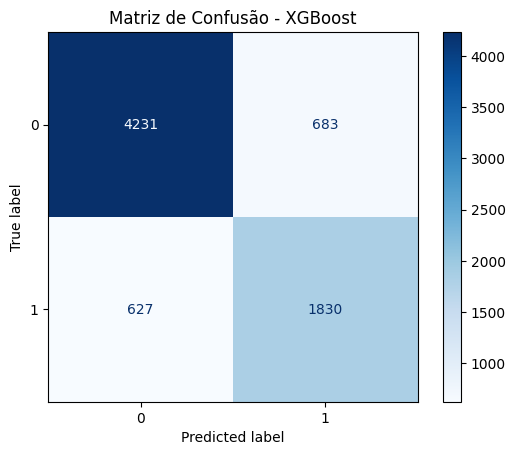

              precision    recall  f1-score   support

           0       0.87      0.86      0.87      4914
           1       0.73      0.74      0.74      2457

    accuracy                           0.82      7371
   macro avg       0.80      0.80      0.80      7371
weighted avg       0.82      0.82      0.82      7371

--- AUC (XGBoost) ---
0.8982


In [7]:
LIMIAR_ESCOLHIDO = 0.45

y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]
# Limiar alterado
y_pred_final = (y_prob_xgb >= LIMIAR_ESCOLHIDO).astype(int)

print("\n--- Matriz de Confusão ---")
cf_matrix = confusion_matrix(y_test, y_pred_final)
ConfusionMatrixDisplay(cf_matrix).plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusão - XGBoost")
plt.show()
print(classification_report(y_test, y_pred_final))


auc_xgb = roc_auc_score(y_test, y_prob_xgb)
print(f"--- AUC (XGBoost) ---")
print(f"{auc_xgb:.4f}")

#### Erro na matrix de confusão: 17,77%
#### Acerto na matriz de confusao: 82,23%

### SHAP (Shapley Additive exPlanations)

In [8]:
explainer_xgb = shap.Explainer(xgb_model.predict_proba, X_train)

shap_values_obj_xgb = explainer_xgb(X_test)

# Gráfico de Resumo Detalhado (Beeswarm) para a classe 1
shap.summary_plot(shap_values_obj_xgb[:, :, 1], X_test, max_display=15, show=True)

# Gráfico de Barras (Importância Global) para a classe 1
shap.summary_plot(shap_values_obj_xgb[:, :, 1], X_test, plot_type="bar", max_display=15, show=True)


PermutationExplainer explainer:  12%|█▏        | 863/7371 [00:49<06:49, 15.91it/s]


KeyboardInterrupt: 

### Salvar modelo

In [9]:
joblib.dump(xgb_model, 'modelo_risco_viario.pkl')
print("Melhor modelo XGBoost salvo com sucesso em 'modelo_risco_viario.pkl'")


Melhor modelo XGBoost salvo com sucesso em 'modelo_risco_viario.pkl'
